In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir(r"C:\Notes\ds_project_portfolio\flight-price-prediction")

FEATURES

1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.
3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.
8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: Target variable stores information of the ticket price.

In [7]:
business_class=pd.read_csv(os.path.join('data','business.csv'))
economy_class=pd.read_csv(os.path.join('data','economy.csv'))

In [8]:
business_class.shape, economy_class.shape

((93487, 11), (206774, 11))

In [9]:
business_class['class']='business'
economy_class['class']='economy'

In [10]:
df=pd.concat([economy_class, business_class],ignore_index=True)

In [11]:
df.duplicated().sum()

2

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(300259, 12)

In [14]:
def categorize_time(time_str):
    hour, minute = map(int, time_str.split(':'))
    
    total_minutes = hour * 60 + minute
    
    if 0 <= total_minutes < 360:  # 00:00 - 05:59
        return 'Late_Night'
    elif 360 <= total_minutes < 480:  # 06:00 - 07:59
        return 'Early_Morning'
    elif 480 <= total_minutes < 720:  # 08:00 - 11:59
        return 'Morning'
    elif 720 <= total_minutes < 1020:  # 12:00 - 16:59
        return 'Afternoon'
    elif 1020 <= total_minutes < 1140:  # 17:00 - 18:59
        return 'Evening'
    elif 1140 <= total_minutes <= 1439:  # 19:00 - 23:59
        return 'Night'
    else:
        return 'Invalid'

In [15]:
def convert_to_minutes(time_str):
    match = re.match(r'(\d+)h\s*(\d+)m', time_str)
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        return hours * 60 + minutes
    else:
        return None

In [16]:
def parse_stops(stop_desc):
    clean_desc = stop_desc.strip().replace('\n', '').replace('\t', '')
    if 'non-stop' in clean_desc.lower():
        return 0
    elif '1-stop' in clean_desc.lower():
        return 1
    elif '2+-stop' in clean_desc.lower():
        return 2

In [17]:
df2=df.copy()
df2['date'] = pd.to_datetime(df2['date'], format='%d-%m-%Y')
today = pd.to_datetime('10-02-2022', format='%d-%m-%Y')
df2['days_prior_booked'] = (df2['date'] - today).dt.days
df2['departure_time'] = df2['dep_time'].apply(categorize_time)
df2['arrival_time'] = df2['arr_time'].apply(categorize_time)
df2['flight_duration'] = df2['time_taken'].apply(convert_to_minutes)
df2['number_of_stops'] = df2['stop'].apply(lambda x: parse_stops(x))

In [19]:
df2.tail()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class,days_prior_booked,departure_time,arrival_time,flight_duration,number_of_stops
300256,2022-03-31,Vistara,UK,822,09:45,Chennai,10h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:50,Hyderabad,"69,265",business,49,Morning,Night,605.0,1
300257,2022-03-31,Vistara,UK,826,12:30,Chennai,10h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,22:55,Hyderabad,"77,105",business,49,Afternoon,Night,625.0,1
300258,2022-03-31,Vistara,UK,832,07:05,Chennai,13h 50m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:55,Hyderabad,"79,099",business,49,Early_Morning,Night,830.0,1
300259,2022-03-31,Vistara,UK,828,07:00,Chennai,10h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:00,Hyderabad,"81,585",business,49,Early_Morning,Evening,600.0,1
300260,2022-03-31,Vistara,UK,822,09:45,Chennai,10h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:50,Hyderabad,"81,585",business,49,Morning,Night,605.0,1


In [4]:
from datetime import date, timedelta
str(date.today()+ timedelta(days=4))

'2024-07-19'

In [14]:
CATEGORICAL_FEATURES=['airline', 'from', 'to', 'class', 'ch_code','departure_time','arrival_time']
NUMERIC_FEATURES=['days_prior_booked','flight_duration','number_of_stops']
TARGET='price'

In [15]:
df2[NUMERIC_FEATURES]=df2[NUMERIC_FEATURES].astype(float)
df2[TARGET] = df2[TARGET].str.strip()
df2[TARGET] = df2[TARGET].str.replace(',', '')
df2[TARGET] = pd.to_numeric(df2[TARGET], errors='coerce')

## EDA

In [16]:
df2[NUMERIC_FEATURES].describe(percentiles=[0.01,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975,0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,25%,50%,75%,90%,95%,97.5%,99%,max
days_prior_booked,300259.0,26.004529,13.560967,1.0,2.0,3.0,4.0,7.0,15.0,26.0,38.0,45.0,47.0,48.0,49.0,49.0
flight_duration,300255.0,733.071306,431.571309,50.0,80.0,110.0,130.0,165.0,405.0,675.0,970.0,1420.0,1555.0,1630.0,1745.0,2990.0
number_of_stops,300259.0,0.924212,0.398189,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0


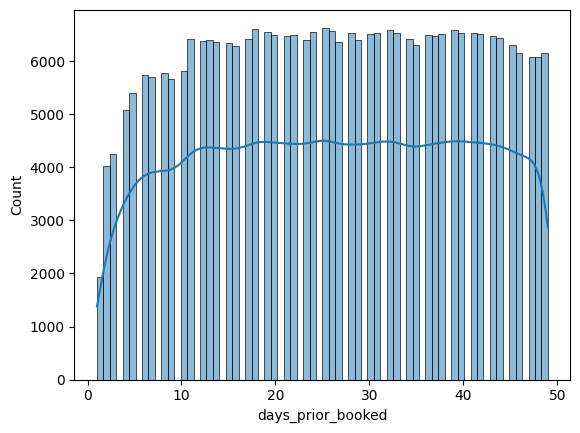

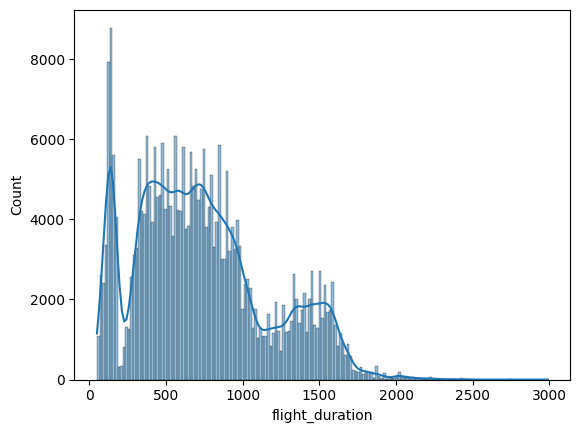

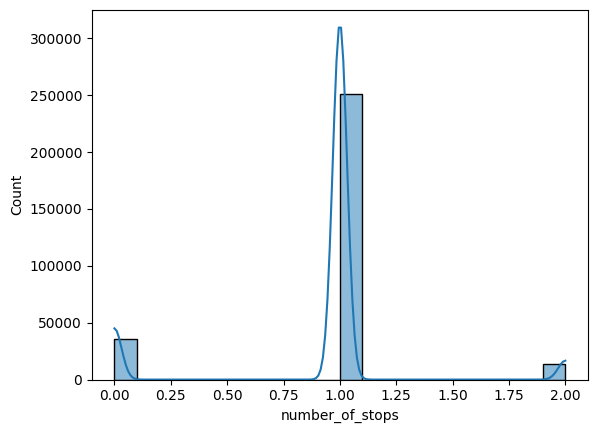

In [17]:
for i in NUMERIC_FEATURES:
    sns.histplot(data=df2,x=i,kde=True)
    plt.show()

numeric features preprocessing:
1. flight_duration: capping the outliers to 99% confidence limit --> lower capping limit 1%, upper capping limit 99%

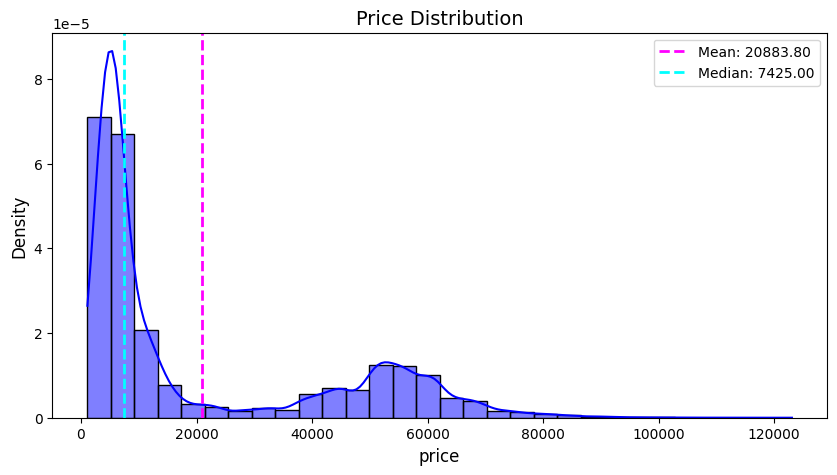

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(df2[TARGET], kde=True, bins=30, color='blue', stat='density')
plt.xlabel(TARGET, fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'{TARGET.capitalize()} Distribution', fontsize=14)
mean_value = df2[TARGET].mean()
median_value = df2[TARGET].median()
plt.axvline(mean_value, color='magenta', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='cyan', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.legend()
plt.show()

In [19]:
df2[TARGET].skew()


1.0618818903392429

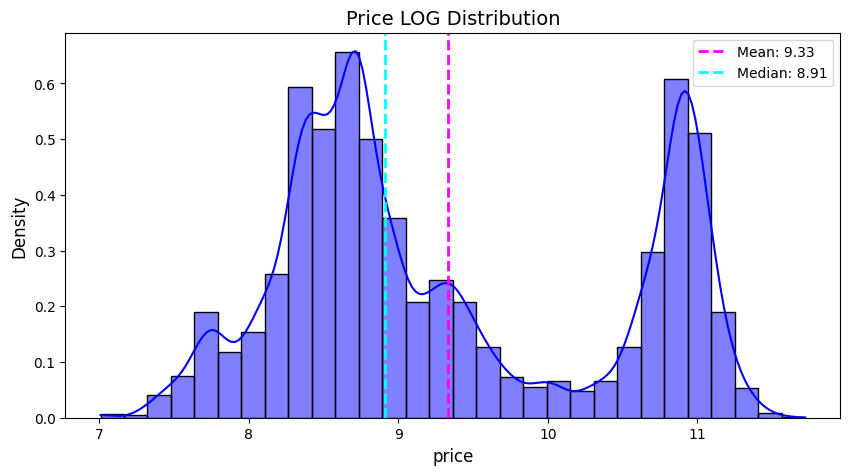

In [20]:
#log transformation
plt.figure(figsize=(10, 5))
sns.histplot(np.log(df2[TARGET]), kde=True, bins=30, color='blue', stat='density')
plt.xlabel(TARGET, fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'{TARGET.capitalize()} LOG Distribution', fontsize=14)
mean_value = np.log(df2[TARGET]).mean()
median_value = np.log(df2[TARGET]).median()
plt.axvline(mean_value, color='magenta', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='cyan', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.legend()
plt.show()

In [21]:
np.log(df2[TARGET]).skew()

0.40469869808173214

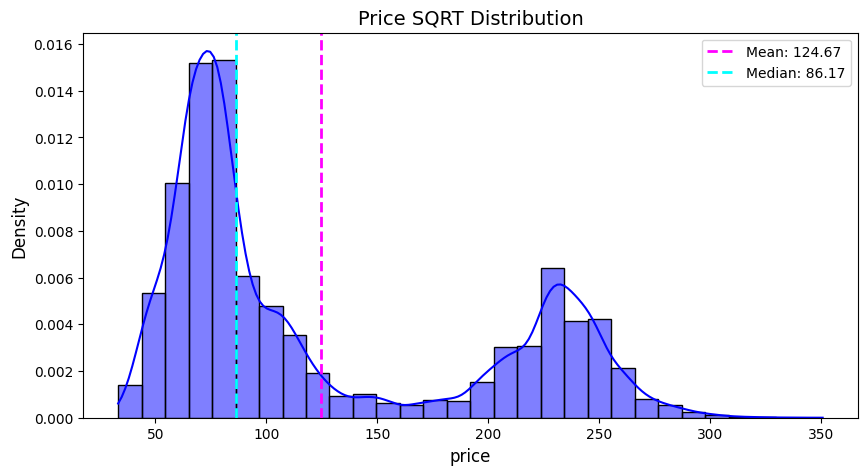

In [22]:
#sqrt transformation
plt.figure(figsize=(10, 5))
sns.histplot(np.sqrt(df2[TARGET]), kde=True, bins=30, color='blue', stat='density')
plt.xlabel(TARGET, fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'{TARGET.capitalize()} SQRT Distribution', fontsize=14)
mean_value = np.sqrt(df2[TARGET]).mean()
median_value = np.sqrt(df2[TARGET]).median()
plt.axvline(mean_value, color='magenta', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='cyan', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.legend()
plt.show()

In [23]:
np.sqrt(df2[TARGET]).skew()

0.7920927185020078

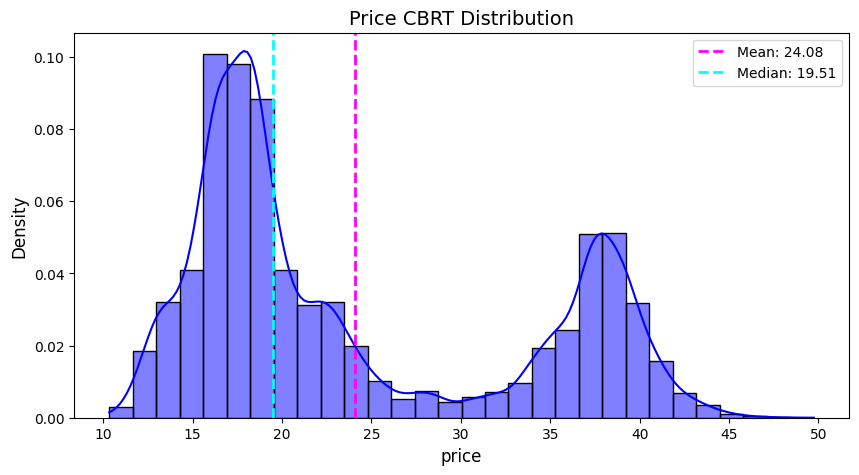

In [24]:
#cbrt transformation
plt.figure(figsize=(10, 5))
sns.histplot(np.cbrt(df2[TARGET]), kde=True, bins=30, color='blue', stat='density')
plt.xlabel(TARGET, fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'{TARGET.capitalize()} CBRT Distribution', fontsize=14)
mean_value = np.cbrt(df2[TARGET]).mean()
median_value = np.cbrt(df2[TARGET]).median()
plt.axvline(mean_value, color='magenta', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='cyan', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.legend()
plt.show()

In [25]:
np.cbrt(df2[TARGET]).skew()

0.6843830763957662

1. Transforming target feature using log transformation to reduce it's skew from 1.06 to 0.41. 

<Axes: title={'center': 'Correlation Analysis'}>

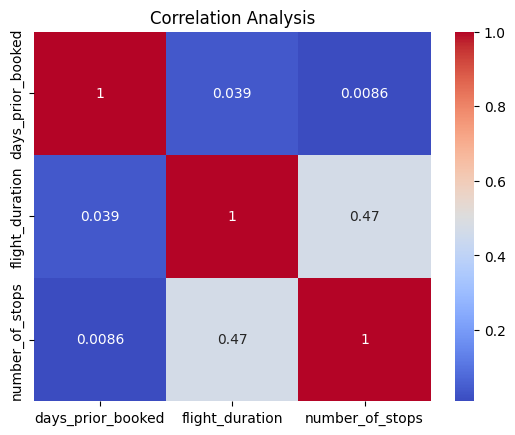

In [26]:
# plt.figure(figsize=(15,8))
plt.title('Correlation Analysis')
correlation = df2[NUMERIC_FEATURES].corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

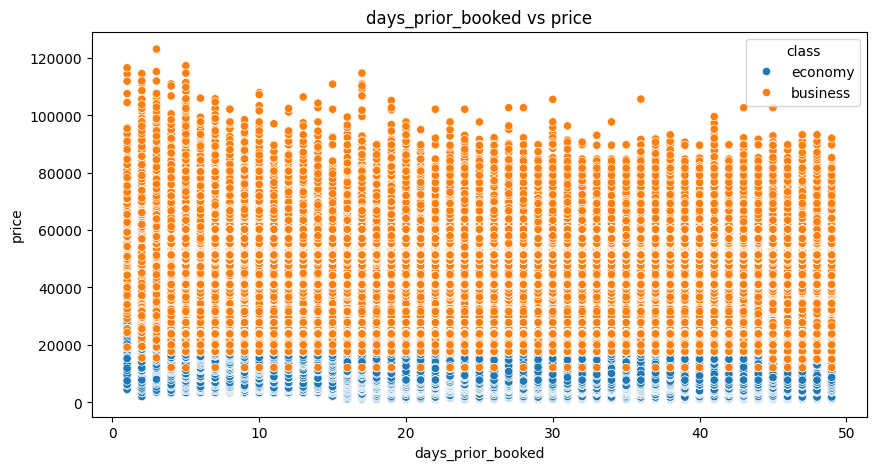

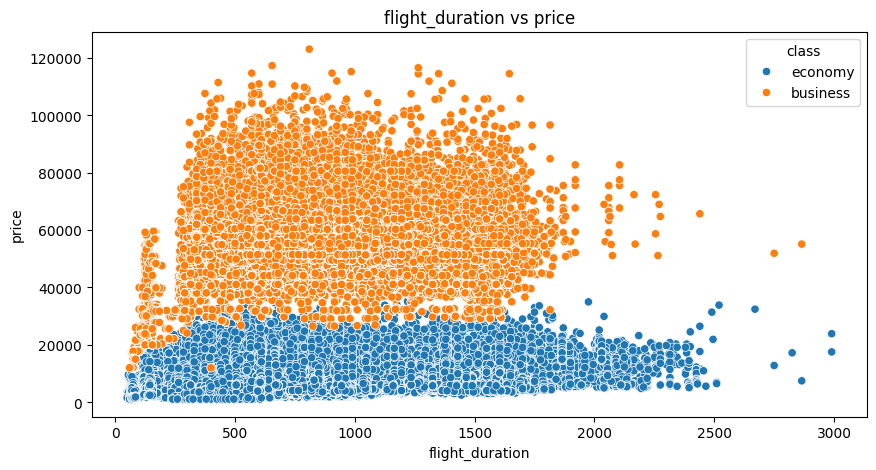

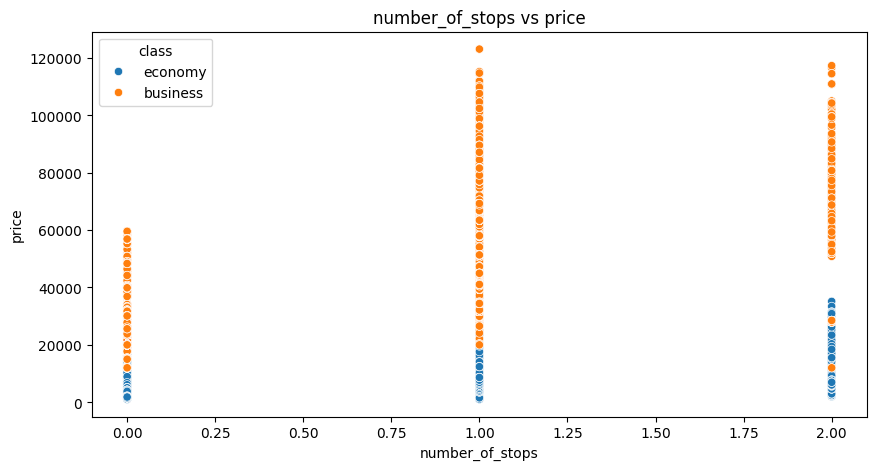

In [27]:
for i in NUMERIC_FEATURES:
  plt.figure(figsize=(10,5))
  sns.scatterplot(x=i,y=TARGET,data=df2,hue='class')
  plt.xlabel(i)
  plt.ylabel(TARGET)
  plt.title(i+' vs '+ TARGET)
  plt.show()

In [28]:
X=df2[CATEGORICAL_FEATURES+NUMERIC_FEATURES]
y=df2[TARGET]

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X
                                               , y
                                               , test_size=0.30
                                               , shuffle=True
                                               , random_state=42)

In [30]:
X_train.shape, X_test.shape

((210181, 10), (90078, 10))

In [31]:
y_train.mean(), y_test.mean()

(20879.373820659337, 20894.128988210217)

In [32]:
def cap_outliers(df, percentile_low=2.5, percentile_high=97.5, req_columns=[]):
    # Select numeric columns
    numeric_cols = df[req_columns]
    
    # Calculate percentiles
    low_perc = numeric_cols.quantile(percentile_low / 100)
    high_perc = numeric_cols.quantile(percentile_high / 100)
    
    # Cap outliers
    df[req_columns] = numeric_cols.clip(lower=low_perc, upper=high_perc, axis=1)
    
    return df, low_perc, high_perc

In [33]:
OUTLIER_COL = ['flight_duration']
X_train, low_perc, high_perc = cap_outliers(X_train
                                            , percentile_low=1
                                            , percentile_high=99
                                            , req_columns=OUTLIER_COL)

# Apply the same cap to test sets
X_test[OUTLIER_COL] = X_test[OUTLIER_COL].clip(lower=low_perc, upper=high_perc, axis=1)

In [34]:
numeric_pipeline=Pipeline(
    steps=[
        ("imputer",SimpleImputer()),
        ("scaler",StandardScaler())
    ]
)

In [35]:
categorical_pipeline=Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="most_frequent")),
        ("onehotencoder",OneHotEncoder(sparse_output=False,drop='if_binary'))
    ]
)

In [36]:
preprocessor=ColumnTransformer(

    [
        ("numeric_pipeline",numeric_pipeline,NUMERIC_FEATURES),
        ("catategorical_pipeline",categorical_pipeline,CATEGORICAL_FEATURES),
    ]
)

In [37]:
preprocessor

ColumnTransformer(transformers=[('numeric_pipeline',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['days_prior_booked', 'flight_duration',
                                  'number_of_stops']),
                                ('catategorical_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 ['airline', 'from', 'to', 'class', 'ch_code',
                                  'departure_time', 'arrival_time'])])

In [38]:
X_train1=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.get_feature_names_out())
X_test1=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.get_feature_names_out())

In [39]:
X_train1.head()

,numeric_pipeline__days_prior_booked,numeric_pipeline__flight_duration,numeric_pipeline__number_of_stops,catategorical_pipeline__airline_Air India,catategorical_pipeline__airline_AirAsia,catategorical_pipeline__airline_GO FIRST,catategorical_pipeline__airline_Indigo,catategorical_pipeline__airline_SpiceJet,catategorical_pipeline__airline_StarAir,catategorical_pipeline__airline_Trujet,catategorical_pipeline__airline_Vistara,catategorical_pipeline__from_Bangalore,catategorical_pipeline__from_Chennai,catategorical_pipeline__from_Delhi,catategorical_pipeline__from_Hyderabad,catategorical_pipeline__from_Kolkata,catategorical_pipeline__from_Mumbai,catategorical_pipeline__to_Bangalore,catategorical_pipeline__to_Chennai,catategorical_pipeline__to_Delhi,catategorical_pipeline__to_Hyderabad,catategorical_pipeline__to_Kolkata,catategorical_pipeline__to_Mumbai,catategorical_pipeline__class_economy,catategorical_pipeline__ch_code_2T,catategorical_pipeline__ch_code_6E,catategorical_pipeline__ch_code_AI,catategorical_pipeline__ch_code_G8,catategorical_pipeline__ch_code_I5,catategorical_pipeline__ch_code_S5,catategorical_pipeline__ch_code_SG,catategorical_pipeline__ch_code_UK,catategorical_pipeline__departure_time_Afternoon,catategorical_pipeline__departure_time_Early_Morning,catategorical_pipeline__departure_time_Evening,catategorical_pipeline__departure_time_Late_Night,catategorical_pipeline__departure_time_Morning,catategorical_pipeline__departure_time_Night,catategorical_pipeline__arrival_time_Afternoon,catategorical_pipeline__arrival_time_Early_Morning,catategorical_pipeline__arrival_time_Evening,catategorical_pipeline__arrival_time_Late_Night,catategorical_pipeline__arrival_time_Morning,catategorical_pipeline__arrival_time_Night
0,1.031770,-0.132066,0.189343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.547997,0.079289,0.189343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.475619,-1.482384,-2.322095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.180632,0.525481,0.189343,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.401873,1.500059,0.189343,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
y_train_transformed=np.log(y_train)
y_test_transformed=np.log(y_test)

In [41]:
y_test_transformed

228853    10.447555
281132    10.547943
11035      9.261319
184067     8.195610
20820      8.691651
            ...    
260320    11.008678
99838      7.673223
200915     7.765993
267387    10.685355
83948      7.544332
Name: price, Length: 90078, dtype: float64

## Model training

In [42]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor


In [43]:
from sklearn.metrics import mean_squared_error,root_mean_squared_error,r2_score,mean_absolute_percentage_error

In [44]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'LGBMRegressor': lgb.LGBMRegressor(),
    'XGBRegressor': XGBRegressor()
}

In [45]:
def evaluate_model(true, pred):
    true=np.exp(true)
    pred=np.exp(pred)
    
    mse = mean_squared_error(true, pred)
    rmse = root_mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    mape = mean_absolute_percentage_error(true, pred)
    
    return mse, rmse, r2, mape

In [46]:
result_df=pd.DataFrame()
mse_list=[]
rmse_list=[]
r2_list=[]
mape_list=[]
mse_list2=[]
rmse_list2=[]
r2_list2=[]
mape_list2=[]

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train1,y_train_transformed)
    y_train_pred=model.predict(X_train1)
    y_pred=model.predict(X_test1)
    mse_train, rmse_train, r2_train, mape_train=evaluate_model(y_train_transformed,y_train_pred)
    mse_test, rmse_test, r2_test, mape_test=evaluate_model(y_test_transformed,y_pred)

    print("model:",model)
    print("TRAIN METRICS:")
    print("mse:",mse_train)
    print("rmse:",rmse_train)
    print("r2:",r2_train)
    print("mape:",mape_train)
    
    print("TEST METRICS:")
    print("mse:",mse_test)
    print("rmse:",rmse_test)
    print("r2:",r2_test)
    print("mape:",mape_test)
    
    mse_list.append(mse_train)
    rmse_list.append(rmse_train)
    r2_list.append(r2_train)
    mape_list.append(mape_train)
    
    mse_list2.append(mse_test)
    rmse_list2.append(rmse_test)
    r2_list2.append(r2_test)
    mape_list2.append(mape_test)
    
    print("="*40)
    print("\n")

model: LinearRegression()
TRAIN METRICS:
mse: 62283656.69736973
rmse: 7891.9995373396805
r2: 0.879069345274565
mape: 0.26292786519708344
TEST METRICS:
mse: 62069326.78920877
rmse: 7878.408899594433
r2: 0.879539134984786
mape: 0.26333079585147984


model: Ridge()
TRAIN METRICS:
mse: 62327605.60423515
rmse: 7894.783442516657
r2: 0.8789840135782017
mape: 0.262965300245795
TEST METRICS:
mse: 62116266.38131864
rmse: 7881.387338617399
r2: 0.8794480371082419
mape: 0.26337986694518506


model: Lasso()
TRAIN METRICS:
mse: 607258833.3348587
rmse: 24642.62229014718
r2: -0.17906064282332856
mape: 1.1406652114861073
TEST METRICS:
mse: 607771805.4861571
rmse: 24653.028322827948
r2: -0.17953135965781852
mape: 1.1476405802205807


model: ElasticNet()
TRAIN METRICS:
mse: 607258833.3348587
rmse: 24642.62229014718
r2: -0.17906064282332856
mape: 1.1406652114861073
TEST METRICS:
mse: 607771805.4861571
rmse: 24653.028322827948
r2: -0.17953135965781852
mape: 1.1476405802205807


model: DecisionTreeRegressor(

In [47]:
result_df['model'] = models.keys()
result_df['train_mse'] = mse_list
result_df['test_mse'] = mse_list2
result_df['train_rmse'] = rmse_list
result_df['test_rmse'] = rmse_list2
result_df['train_r2'] = r2_list
result_df['test_r2'] = r2_list2
result_df['train_mape'] = mape_list
result_df['test_mape'] = mape_list2

In [48]:
result_df

,model,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,train_mape,test_mape
0,LinearRegression,6.228366e+07,6.206933e+07,7891.999537,7878.408900,0.879069,0.879539,0.262928,0.263331
1,Ridge,6.232761e+07,6.211627e+07,7894.783443,7881.387339,0.878984,0.879448,0.262965,0.263380
2,Lasso,6.072588e+08,6.077718e+08,24642.622290,24653.028323,-0.179061,-0.179531,1.140665,1.147641
3,ElasticNet,6.072588e+08,6.077718e+08,24642.622290,24653.028323,-0.179061,-0.179531,1.140665,1.147641
4,DecisionTreeRegressor,2.886607e+05,1.209572e+07,537.271523,3477.889798,0.999440,0.976525,0.002492,0.074071
5,KNeighborsRegressor,1.235822e+07,1.883570e+07,3515.426046,4340.011660,0.976005,0.963445,0.087778,0.114280
6,AdaBoostRegressor,3.378641e+07,3.389514e+07,5812.607626,5821.952912,0.934400,0.934218,0.282862,0.284821
7,GradientBoostingRegressor,2.609845e+07,2.629445e+07,5108.664572,5127.811805,0.949327,0.948969,0.181385,0.182641
8,RandomForestRegressor,1.334686e+06,7.426781e+06,1155.286199,2725.212131,0.997409,0.985586,0.025625,0.066247
9,LGBMRegressor,1.945026e+07,1.956606e+07,4410.245414,4423.353643,0.962235,0.962027,0.149689,0.150994


1. From the above table, we find that RandomForestRegressor has the lowest RMSE, and the highest R2 scores on the test set. Hence, this model can be put into production.